# Homework  - Diffusion Models
### Sharif University - Deep Learning Course - Spring 2024

*Instructor:  Dr. Soleymani*

---

*Full Name:* Mehdi Jamalkhah

*SID:*

---

This homework helps you implement a Denoising Diffusion Probabilistic Model (DDPM).  
For references please refer to the original [DDPM paper](https://arxiv.org/pdf/2006.11239.pdf).

In this homework you need to complete the notebook and run all the cells.
We have specified the parts to be completed with `TODO` tags inside the code blocks.

**NOTES**:
* It is important that you read all the code and text blocks carefully, even if you think you are excited to jump into completing the missing codes.
* This notebook is tested with *Google Colab* and *Kaggle* free runtimes and you can used them for testing your code.
* Ensure all cells are executable and perform their intended functions
* You can ask your questions on [Quera Class](https://quera.org/course/16605/)
* Write clear, commented code when necessary.

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL/HW4'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
os.chdir(GOOGLE_DRIVE_PATH)
print(os.listdir('./'))

Mounted at /content/drive
['data', 'vars', 'ddpm.pth']


# Denoising Diffusion Probabilistic Models (DDPMs) (100 + 20 points)

## Introduction

Denoising Diffusion Probabilistic Models (DDPM) are deep generative models that are recently getting a lot of attention due to their impressive performances. Brand new models like OpenAI’s DALL-E 2 and Google’s Imagen generators are based on DDPMs.

The idea is quite simple: given a dataset of images, we add a little bit of noise step-by-step. With each step, the image becomes less and less clear, until all that is left is noise. This is called the “forward process”. Then, we learn a machine learning model that can undo each of such steps, and we call it the “backward process”. If we can successfully learn a backward process, we have a model that can generate images from pure random noise.

A step in the forward process consists in making the input image noisier (x at step t) by sampling from a multivariate gaussian distribution which mean is a scaled-down version of the previous image (x at step t-1) and which covariance matrix is diagonal and fixed. In other words, we perturb each pixel in the image independently by adding some normally distributed value:

![image](https://learnopencv.com/wp-content/uploads/2023/01/diffusion-models-forwardbackward_process_ddpm.png "The main idea of DDPM: Map images x0 to more and more noisy images with probability distribution q. Then, learn the inverse function p parametrized by parameters theta. The image is taken from “Denoising DIffusion Probabilistic Models” by Ho et. al.")

For the backward process, we know our model should also work as a gaussian distribution, so we would just need the model to predict the distribution mean and standard deviation given the noisy image and time step. In practice, in this first paper on DDPMs the covariance matrix is kept fixed, so we only really want to predict the mean of the gaussian (given the noisy image and the time step we are at currently):

![image](https://learnopencv.com/wp-content/uploads/2023/02/denoising-diffusion-probabilistic-models-overall_forward_diffusion_process-1.png)

We will delve deeper into the details of the forward (diffusion) and backward (denoising) processes in the relevant cells.

In this homework, we aim to implement a DDPM from scratch to generate random captcha images from noise. Our goal is to make our DDPM conditional on the captcha text to generate images for specific input texts.

## Packages

As usual, imports are trivially our first step.



In [2]:
import os
import random
import string
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
from torchvision.datasets import VisionDataset
# from transformers import AutoTokenizer, AutoModel

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
CUDA = 'cuda:0'
DEVICE = CUDA if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

## Dataset (3 points)
We'll focus on the small captcha dataset comprising around 1070 images, each labeled with a 5-character text (lowercase letters and digits). The dataset represents a tiny fraction of the total possible captchas, estimated at 5^36. Our aim is to generate new captchas not present in the provided dataset. Each sample is a 50x200 RGB image paired with a text label. To begin, download our data and create a custom vision dataset by running the following two cells:

In [ ]:
%%capture
!pip install gdown
!gdown 1P_EQv94d03y59kFPQ2gZLOLMAJs6cLVI

In [4]:
class Captcha(VisionDataset):
    def __init__(self, root, transform=None, target_transform=None):
        # Initializing Captcha Dataset class
        super(Captcha, self).__init__(root, transform=transform, target_transform=target_transform)
        # Listing all files in the provided root directory
        self.files = sorted(os.listdir(root))

        # Initializing lists to store images and their respective labels
        self.images = []
        self.labels = []

        # Iterating through each file in the root directory
        for img in self.files:
            # Checking if the file is an image file
            if self.is_image_file(img):
                # Extracting label from filename (before the extension)
                name = os.path.basename(img)
                label = name.split('.')[0]
                # Storing image path and label
                self.images.append(os.path.join(self.root, img))
                self.labels.append(label)

    def __len__(self):
        # Returning the total number of images
        return len(self.labels)

    def __getitem__(self, idx:int):
        # Retrieving image and target label based on index
        img, target = self.images[idx], self.labels[idx]

        # Checking if the index is a slice (multiple items requested)
        if isinstance(idx, slice):
            tmp = []
            # Iterating through each image in the slice
            for item in img:
                # Applying transformations if specified
                if self.transform is not None:
                    tmp.append(self.transform(self.read_image(item)))
                else:
                    tmp.append(self.read_image(item))
            img = tmp
        else:
            # Applying transformations if specified
            if self.transform is not None:
                img = self.transform(self.read_image(img))
            else:
                img = self.read_image(img)

        # Applying target transformations if specified
        if self.target_transform is not None:
            if isinstance(idx, slice):
                tmp = []
                # Iterating through each target label in the slice
                for t in target:
                    tmp.append(self.target_transform(t))
                target = tmp
            else:
                target = self.target_transform(target)

        # Returning image and target label
        return img, target

    # Method to read image from file path
    def read_image(self, path):
        img = Image.open(path)
        # Converting image to RGB format
        return img.convert('RGB')

    # Method to check if a file is an image file
    def is_image_file(self, filename):
        # Checking if filename ends with any of the specified image extensions
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])


The images we read are in PIL format via the Pillow library. Initially, we apply below transforms to the raw images:
* rezie them to a final size of `64 by 256`
* converting them into a tensor
* and normalizing values to a `mean` and `standard deviation` of 0.5.

In [5]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
transform = transforms.Compose(
    [
        transforms.Resize((64, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
)

#################### END TODO ############################
# For now we skip target transform but define if it is needed.
target_transform = None

In [6]:
# Defining the path where the dataset is stored
DATA_PATH = 'data/captcha_v2/'

dataset = Captcha(DATA_PATH, transform, target_transform)

In the next step, we utilize the `dataloader` for model training and `plot_samples` to visualize sequences of images, such as iteratively denoised images by DDPM.

In [7]:
# Define your desired batch size for training or evaluation
BATCH_SIZE = 8

# Create a Dataloader instance for loading data in batches
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True, num_workers=2)

In [8]:
# Define function to plot images
def plot_images(images):
    plt.figure(figsize=(16, 3))
    # Concatenate the images along the horizontal axis and convert the resulting tensor to CPU
    # Then permute the dimensions to change the order of the axes from (C, H, W) to (H, W, C)
    # Finally, normalize the pixel values to the range [0, 1] by dividing by 2 and adding 0.5
    plt.imshow(torch.cat([i for i in images], dim=-1).permute(1, 2, 0).cpu() / 2 + 0.5)

    plt.axis('off')

    plt.show()


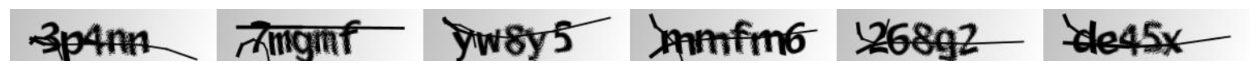

In [9]:
# gettng some random samples from our dataset
# Define the number of samples to display
num_samples = 6
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:num_samples])

## DDPM Architecture(55 + 3 points)

The overall procedure of training and sampling from DDPM is represented in the following pseudocodes from DDPM paper. For more details on the loss function and the sampling process, please refer to the course slides and the paper.
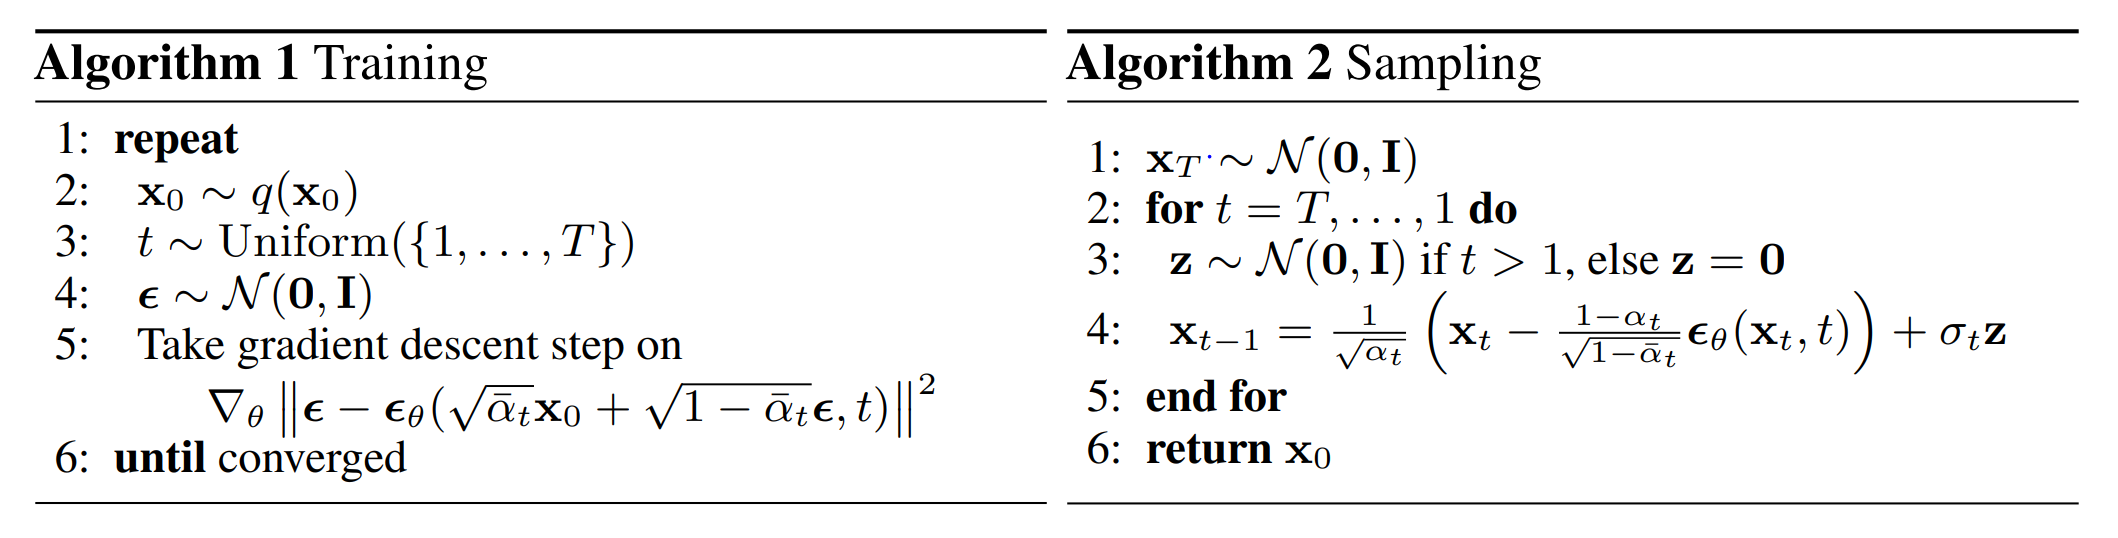

According to the given pseudocode, In the reverse diffusion process, the task is to learn a finite-time (within T timesteps) reversal of the forward diffusion process. So we only need to train a model that learns to reverse the noise from an input image at a specific time step. In this notebook, we will use the fully convolutional network architecture proposed by the paper, a U-Net with image and time as the inputs and predicted noise as the output. They augment the regular UNet with several sub-modules and techniques such as ResNets, Attention modules and etc. We describe The UNet network and its architecture in the next section.

The pseudocode also shows that the loss function is defined as an MSE on per time step noise and the predicted noise for the current time step. Therefore, we will also use the mentioned loss function to train the network. The pseudo-code provides the formula for generating both noisy and less noisy images, that will be used in the relevant section.


### U-Net

The U-Net architecture, a convolutional neural network framework, has emerged as a powerful tool for semantic segmentation tasks, U-Net is characterized by its unique U-shaped architecture, that allows U-Net to efficiently learn both global and local features, enabling it to achieve best performance in various segmentation challenges.
![unet_ong](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU.

The figure above illustrates the 2015 U-Net architecture. However, for this homework, we require a customized version with additional sub-modules. In the following cells, we will outline the necessary modules and complete their implementation to construct our final network.

#### Resnet Block

As a base sub-module, we define each Resnet block as two consecutive convolutional layers with a Group Normalization and SiLU activation `before` each convolutional layer. This block will be used other sub-modules (eg:Down/Up blocks):
* GroupNorm
* SiLU
* Conv
* GroupNorm
* SiLU
* Conv

Additionally, there's a linear projection layer that converts the time embedding vector to a vector matching the number of output channels. This projected time embedding is then added to the input after the first convolutional layer. Also, by removing the residual connection, you can use this block as a convolutional network.

Note that if the number of input and output channels for feature maps differs, adding the input to the output for a residual connection may cause issues. In such cases, a 1x1 convolution can be used to ensure input channels match the output dimensions.

Optionally, a dropout layer can added before the second convolution layer. By default, its probability is set to zero, but you can activate it if necessary in your final architecture.

In [10]:
class ResnetBlock(nn.Module):
    """
    Residual block for U-Net architecture.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
        temb_size (int): Size of the time embedding.
        dropout (float, optional): Dropout probability. Default is 0.
        norm_groups (int, optional): Number of groups to separate normalization. Default is 1.
        residual (bool, optional): Whether to include residual connection. Default is True.
    """

    def __init__(self, in_ch, out_ch, temb_size, dropout=0, norm_groups=1, residual=True, **kwargs):
        super(ResnetBlock, self).__init__()
        kernel_size = 3
        padding = 'same'
        bias = True
        self.residual = residual
        self.stack1 = nn.Sequential(
            nn.GroupNorm(norm_groups, in_ch),
            nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, kernel_size, padding=padding)
        )
        self.time_projction = nn.Linear(temb_size, out_ch)
        self.stack2 = nn.Sequential(
            nn.GroupNorm(norm_groups, out_ch),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, kernel_size, padding=padding)
        )
        if in_ch != out_ch:
            self.skip_shortcut = nn.Conv2d(in_ch, out_ch, kernel_size=1)
        else:
            self.skip_shortcut = nn.Identity()




    def forward(self, x, t):
        """
        Forward pass of the ResnetBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        out = self.stack1(x) + self.time_projction(t).unsqueeze(-1).unsqueeze(-1)
        out = self.stack2(out)

        if self.residual:
            out += self.skip_shortcut(x)

        return out


In [ ]:
# test your block
test_module = ResnetBlock(128, 256, 32)
temb = torch.randn(1, 32)
noisy_sample = torch.randn(1, 128, 64, 64)
output = test_module(noisy_sample, temb)
assert noisy_sample.shape[2:] == output.shape[2:]
assert output.shape[1] == 256
output.shape

torch.Size([1, 256, 64, 64])

#### Attention Block
This sub-module consisting of :
 * a Group Normalization
 * Multi-head Attention (you can use `torch.nn`)
 * residual conntection
 * a feed-forward layer
 * and another residual connection.

**Note:** In `nn.MultiheadAttention`, there's a `need_weights` parameter that returns attention weights. Set this parameter to false to save GPU memory.

Same as Resnet block, you can add an optional dropout layer after the feed-forward layer. By default, its probability is set to zero, but you can activate it if necessary in your final architecture.

**Bonus:** Implement multihead attention from scratch and utilize it in the attention block.


In [11]:
class SelfAttentionHead(nn.Module):
    def __init__(self, n_embd, head_size):
        super().__init__()

        self.head_size = head_size
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

    def forward(self, x):
        K = self.key(x)
        Q = self.query(x)
        V = self.value(x)
        alignment = torch.bmm(Q, K.permute(0, 2, 1)) / np.sqrt(self.head_size)
        attention = torch.softmax(alignment, dim=-1)
        out = torch.bmm(attention, V)

        return out


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, num_heads, n_embd, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttentionHead(n_embd, head_size) for i in range(num_heads)])
        self.projection = nn.Linear(head_size*num_heads, n_embd)
    def forward(self, x):
        out = torch.concatenate([head(x) for head in self.heads], dim=-1)
        out = self.projection(out)
        return out

class AttentionBlock(nn.Module):
    """
    Initializes the AttentionBlock module.

    Args:
        feature_dim (int): Dimensionality of input features.
        num_heads (int): Number of attention heads to use.
        norm_groups (int): Number of groups to split the input into for normalization.
        dropout (float): Dropout probability.
        **kwargs: Additional keyword arguments.
    """
    def __init__(self, feature_dim, num_heads=4, norm_groups=1, dropout=0, **kwargs):

        super(AttentionBlock, self).__init__()
        self.norm = nn.GroupNorm(norm_groups, feature_dim)
        self.attention = MultiHeadSelfAttention(num_heads, feature_dim, head_size=feature_dim//num_heads)
        self.fc = nn.Linear(feature_dim, feature_dim)
        self.drop = nn.Dropout(dropout)


    def forward(self, x):
        """
        Forward pass of the AttentionBlock module.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, feature_dim).

        Returns:
            torch.Tensor: Output tensor after applying attention mechanism and normalization.
        """
        batch, features, h, w = x.shape

        out = self.norm(x)

        out = out.view(batch, features, h * w).transpose(1, 2).clone()
        x = x.view(batch, features, h * w).transpose(1, 2).clone()

        out = self.attention(out)

        x += out
        out = self.fc(x)
        out += x
        return out.transpose(1, 2).view(batch, features, h, w)

In [ ]:
# test your block
test_module = AttentionBlock(128)
noisy_sample = torch.randn(1, 128, 64, 64)
output = test_module(noisy_sample)
assert noisy_sample.shape == output.shape
output.shape

torch.Size([1, 128, 64, 64])

#### Down Block

This block is a downsampling block comprised of a series of ResnetBlocks, followed by a downsampling module. The number of **ResnetBlocks** is determined by `num_layers`, also input channels for the first ResnetBlock is `in_ch`, and the output channels for last one is `out_ch`, which should be considered in your implementation.

The downsampling module halves the width and height of the input and can be implemented using either a convolution layer with `stride=2` or an average pooling layer with `kernel_size=2`, depending on your architecture.

Select the appropriate layer for your architecture.

Sometimes, there's a need for a DownBlock without a downsampling module, in this case, the `add_sampling` parameter is `False`.

The `forward` method of this block should return two values:
1. The processed input tensor through ResnetBlocks and the downsampling module (if it exists).
2. The output of each ResnetBlock and the downsampling layer (if it exists) that are used in the expansive path (upsample) of the U-Net.

In [12]:
class DownBlock(nn.Module):
    """
    DownBlock class defines a block for downsampling in U-Net.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
        temb_size (int): Size of the time embedding.
        dropout (float): Dropout rate.
        norm_groups (int): Number of groups for normalization.
        num_layers (int, optional): Number of Resnet layers. Defaults to 1.
        add_sampling (bool, optional): Whether to add downsampling. Defaults to True.
    """
    def __init__(self, in_ch, out_ch, temb_size, dropout, norm_groups, num_layers=1, add_sampling=True, **kwargs):
        super(DownBlock, self).__init__()

        self.add_sampling = add_sampling

        self.res_blocks = [ResnetBlock(in_ch, out_ch, temb_size, dropout, norm_groups)]
        for i in range(num_layers - 1):
            self.res_blocks.append(ResnetBlock(out_ch, out_ch, temb_size, dropout, norm_groups))
        self.res_blocks = nn.ModuleList(self.res_blocks)
        self.sampler = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=2, padding=1)


    def forward(self, x, t):
        """
        Forward pass through the DownBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): ime embedding tensor..

        Returns:
            torch.Tensor: Output tensor.
            tuple: Hidden states.
        """
        hidden_states = [x]
        for block in self.res_blocks:
            x = block(x, t)
            hidden_states.append(x)
        if self.add_sampling:
            x = self.sampler(x)

        return x, tuple(hidden_states)




In [ ]:
# test your block
test_module1 = DownBlock(128, 256, 128, 0 , 32,)
test_module2 = DownBlock(128, 256, 128, 0 , 32, 3, add_sampling=False)
temb = torch.randn(1, 128)
noisy_sample = torch.randn(1, 128, 64, 64)
output1, hidden1 = test_module1(noisy_sample, temb)
output2, hidden2 = test_module2(noisy_sample, temb)
assert noisy_sample.shape[2] == output1.shape[2] * 2
assert noisy_sample.shape[2] == output2.shape[2]
assert output1.shape[1] == 256
assert output2.shape[1] == 256
assert len(hidden1) == 2
assert len(hidden2) == 4
print('successful.')

successful.


#### AttentionDown Block

This block is similar to the DownBlock but with two differences:

1. There's an Attention Block after each ResnetBlock, resulting in `num_layers` ResnetBlocks and `num_layers` AttentionBlocks.
2. The downsampling module is always present.

Note that you can choose between two types of downsampling modules, similar to the DownBlock.

In [13]:
class AttentionDownBlock(nn.Module):
    """
    AttntionDownBlock class defines a block for downsampling with attention mechanism.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
        temb_size (int): Size of the time embedding.
        dropout (float): Dropout rate.
        norm_groups (int): Number of groups for normalization.
        num_layers (int, optional): Number of layers. Defaults to 1.
        num_heads (int, optional): Number of attention heads. Defaults to 8.
        **kwargs: Additional keyword arguments.
    """
    def __init__(self, in_ch, out_ch, temb_size, dropout, norm_groups, num_layers=1, num_heads=8, **kwargs):
        super(AttentionDownBlock, self).__init__()
        self.res_blocks = [ResnetBlock(in_ch, out_ch, temb_size, dropout, norm_groups)]
        for i in range(num_layers-1):
            self.res_blocks.append(ResnetBlock(out_ch, out_ch, temb_size, dropout, norm_groups))

        self.atten_blocks = nn.Sequential(
            *[AttentionBlock(out_ch, num_heads, norm_groups, dropout) for i in range(num_layers)]
        )

        self.res_blocks = nn.ModuleList(self.res_blocks)
        self.sampler = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=2, padding=1)

    def forward(self, x, t):
        """
        Forward pass through the AttntionDownBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.

        Returns:
            torch.Tensor: Output tensor.
            tuple: Hidden states.
        """
        hidden_states = [x]
        for block in self.res_blocks:
            x = block(x, t)
            hidden_states.append(x)
        x = self.atten_blocks(x)

        x = self.sampler(x)

        return x, tuple(hidden_states)


In [ ]:
# test your block
test_module = AttentionDownBlock(128, 256, 128, 0 , 32,3)
temb = torch.randn(1, 128)
noisy_sample = torch.randn(1, 128, 64, 64)
output, hidden = test_module(noisy_sample, temb)
assert noisy_sample.shape[2] == output1.shape[2] * 2
assert output.shape[1] == 256
assert len(hidden) == 4
print('successful.')

successful.


#### Up Block
This block is utilized in the expansive path of the U-Net. Its architecture resembles the DownBlocks, consisting of `num_layers` consecutive ResnetBlocks. Following the ResnetBlocks, there's an upsample module with two possible options based on the network architecture:

* An upsample layer followed by a convolution layer.
* A convolution transpose layer with appropriate parameters.

The UpBlock also includes an extra parameter, `skip_ch`, indicating the number of channels in the skip connection from the contractive path. Note that these skip channels affect the number of input channels of the ResnetBlocks, which should be considered in your implementation.

In the forward method, in addition to the input tensor and time embedding tensor, it takes the hidden states from the contractive path of the U-Net as the third input. Each hidden state is concatenated with the input before processing it through a ResnetBlock.


In [14]:
class UpBlock(nn.Module):
    """
    UpBlock class defines a block for upsampling in U-Net.

    Args:
        in_ch (int): Number of input channels.
        skip_ch (int): Number of channels in skip connection.
        out_ch (int): Number of output channels.
        temb_size (int): Size of the time embedding.
        dropout (float): Dropout rate.
        norm_groups (int): Number of groups for normalization.
        num_layers (int, optional): Number of layers. Defaults to 1.
        add_sampling (bool, optional): Whether to add upsampling. Defaults to True.
        **kwargs: Additional keyword arguments.
    """
    def __init__(self, in_ch, skip_ch, out_ch, temb_size, dropout, norm_groups, num_layers=1, add_sampling=True, **kwargs):
        super(UpBlock, self).__init__()
        self.add_sampling = add_sampling
        self.res_blocks = []
        for i in range(num_layers):
            res_skip_channels = skip_ch if (i == num_layers - 1) else in_ch
            res_in_channels =  in_ch if i == 0 else out_ch

            self.res_blocks.append(ResnetBlock(res_in_channels + res_skip_channels, out_ch, temb_size, dropout, norm_groups))

        self.res_blocks = nn.ModuleList(self.res_blocks)
        self.sampler = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        )

    def forward(self, x, t, hidden_states):
        """
        Forward pass through the UpBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.
            hidden_states (tuple): Tuple of hidden states from contractive path.

        Returns:
            torch.Tensor: Output tensor.
        """
        for block, hidden_state in zip(self.res_blocks, reversed(hidden_states)):
            x = torch.concatenate([hidden_state, x], axis=1)
            x = block(x, t)

        if self.add_sampling:
            x = self.sampler(x)

        return x

In [ ]:
# test your block
test_module = UpBlock(256 ,128, 256, 128, 0 , 32,3)
temb = torch.randn(1, 128)
noisy_sample = torch.randn(1, 256, 64, 64)
hidden_states = (torch.randn(1, 128, 64, 64), torch.randn(1, 256, 64, 64), torch.randn(1, 256, 64, 64))
output = test_module(noisy_sample, temb, hidden_states)
assert noisy_sample.shape[2] * 2  == output.shape[2]
assert output.shape[1] == 256
print('successful.')

successful.


#### AttentionUp Block
This block shares the same architecture as the UpBlock, with an additional attention block after each ResnetBlock. Furthermore, it includes an upsample module, similar to the UpBlock, following the Resnet and attention blocks.

In [15]:
class AttentionUpBlock(nn.Module):
    """
    AttentionUpBlock class defines a block for upsampling with attention mechanism.

    Args:
        in_ch (int): Number of input channels.
        skip_ch (int): Number of channels in skip connection.
        out_ch (int): Number of output channels.
        temb_size (int): Size of the time embedding.
        dropout (float): Dropout rate.
        norm_groups (int): Number of groups for normalization.
        num_layers (int, optional): Number of layers. Defaults to 1.
        num_heads (int, optional): Number of attention heads. Defaults to 8.
        **kwargs: Additional keyword arguments.
    """

    def __init__(self, in_ch, skip_ch, out_ch, temb_size, dropout, norm_groups, num_layers=1, num_heads=8, **kwargs):
        super(AttentionUpBlock, self).__init__()
        self.res_blocks = []
        for i in range(num_layers):
            res_skip_channels = skip_ch if (i == num_layers - 1) else in_ch
            res_in_channels =  in_ch if i == 0 else out_ch

            self.res_blocks.append(ResnetBlock(res_in_channels + res_skip_channels, out_ch, temb_size, dropout, norm_groups))
        self.res_blocks = nn.ModuleList(self.res_blocks)

        self.atten_blocks = nn.Sequential(
            *[AttentionBlock(out_ch, num_heads, norm_groups, dropout) for i in range(num_layers)]
        )
        self.sampler = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        )

    def forward(self, x, t, hidden_states):
        """
        Forward pass through the AttentionUpBlock.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor):  Time embedding tensor.
            hidden_states (tuple): Tuple of hidden states.

        Returns:
            torch.Tensor: Output tensor.
        """
        for block, hidden_state in zip(self.res_blocks, reversed(hidden_states)):
            x = torch.concatenate([hidden_state, x], axis=1)
            x = block(x, t)

        x = self.atten_blocks(x)
        x = self.sampler(x)

        return x

In [ ]:
# test your block
test_module = AttentionUpBlock(256 ,128, 256, 128, 0 , 32, 3)
temb = torch.randn(1, 128)
noisy_sample = torch.randn(1, 256, 64, 64)
hidden_states = (torch.randn(1, 128, 64, 64), torch.randn(1, 256, 64, 64), torch.randn(1, 256, 64, 64))
output = test_module(noisy_sample, temb, hidden_states)
assert noisy_sample.shape[2] * 2  == output.shape[2]
assert output.shape[1] == 256
print('successful.')

successful.


#### Mid Block
In the U-Net architecture, there are bottleneck layers between the contractive and expansive paths. These can be implemented using ResnetBlocks with or without attention layers. Specifically, we define the MidBlock with `num_layers` of ResnetBlocks having the same number of input and output channels, followed by an AttentionBlock.

In [16]:
class MidBlock(nn.Module):
    """
    A module containing a stack of ResNet blocks followed by an attention block.

    Args:
        in_ch (int): Number of input channels.
        temb_size (int): Size of the time embedding.
        dropout (float): Dropout probability.
        norm_groups (int): Number of groups for layer normalization.
        num_layers (int, optional): Number of ResNet blocks. Defaults to 1.
        num_heads (int, optional): Number of attention heads. Defaults to 8.
    """
    def __init__(self, in_ch, temb_size, dropout, norm_groups, num_layers=1, num_heads=8, **kwargs):
        super(MidBlock, self).__init__()

        self.res_blocks = nn.Sequential(
            *[ResnetBlock(in_ch, in_ch, temb_size, dropout, norm_groups) for i in range(num_layers)]
        )
        self.atten_block = AttentionBlock(in_ch, num_heads, norm_groups, dropout)
        self.stack = nn.Sequential(
            nn.Linear(in_ch, in_ch),
            nn.Dropout(dropout)
        )

    def forward(self, x, t):
        """
        Forward pass through the MidBlock module.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Time embedding tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        for block in self.res_blocks:
            x = block(x, t)
        x = self.atten_block(x)
        x = x.permute(0, 2, 3, 1)
        x = self.stack(x)
        x = x.permute(0, 3, 1, 2)

        return x

In [ ]:
# test your block
test_module = MidBlock(256 ,128, 0, 32)
temb = torch.randn(1, 128)
noisy_sample = torch.randn(1, 256, 64, 64)
output = test_module(noisy_sample, temb)
assert noisy_sample.shape  == output.shape
print('successful.')

successful.


#### Positional Encoding
In previous sections, we discussed how U-Net predicts noise at each time step. To incorporate the time step into the network, we encode it into an embedding vector and pass it to various layers. Various position encoding methods exist, but we use Sinusoidal position embeddings proposed in the ["Attention is All You Need."](https://arxiv.org/pdf/1706.03762.pdf) paper for this purpose. For more technical details, please refer to the paper.

In [17]:
class SinusoidalPosition(nn.Module):
    """
    A module to create sinusoidal positional embeddings.

    Args:
        embedding_dim (int): Dimensionality of the positional embeddings.
        max_period (int, optional): Controls the minimum frequency of the embeddings. Defaults to 10000.
    """

    def __init__(self, embedding_dim, max_period=10000):
        super(SinusoidalPosition, self).__init__()
        self.max_period = max_period
        self.embedding_dim = embedding_dim


    def forward(self, timesteps: torch.Tensor):
        """
        Forward pass to create sinusoidal positional embeddings.

        Args:
            timesteps (torch.Tensor): A 1-D Tensor of N indices, one per batch element.

        Returns:
            torch.Tensor: An [N x dim] Tensor of positional embeddings.
        """
        assert len(timesteps.shape) == 1, "Timesteps should be a 1d-array"
        emb = torch.zeros(self.embedding_dim, len(timesteps), device= timesteps.device)
        for k in range(self.embedding_dim // 2):
            w = 1 / (self.max_period ** (2 * (k + 1) / self.embedding_dim))
            emb[2 * k] = torch.sin(w * timesteps)
            emb[2 * k + 1] = torch.cos(w * timesteps)
        return emb.T

#### Final Network
In this section, we'll construct our U-Net architecture using the blocks defined above. The architecture of the network varies depending on the problem we want to solve. However, for simplicity, we propose a basic architecture suitable for our captcha generation problrm. Feel free to define and test your own architecture for captcha generation.
Proposed Contractive Path Architecture:
- Convolution layer (in_ch > 128)
- DownBlock (128 > 128), num_layers=2
- DownBlock (128 > 128), num_layers=2
- DownBlock (128 > 256), num_layers=2
- AttentionDownBlock (256 > 256), num_layers=2
- AttentionDownBlock (256 > 512), num_layers=2
- DownBlock (512 > 512, without sampling)

Proposed Bottleneck Architecture:
- MidBlock

Proposed Expansive Path Architecture (calculate input and skip channels depending on the contractive path):
- UpBlock
- AttentionUpBlock
- AttentionUpBlock
- UpBlock
- UpBlock
- UpBlock (without sampling)
- (Optional) Group norm + SiLU
- Convolution layer

Notes:
- Use num_layers=2 for all Down and AttentionDown blocks in the contractive path.
- Number of layers in the expansive path should be (number of layers in contractive path + 1). So, if num_layers=2 is used in contractive layers, num_layers=3 should be used in the expansive path.
- Create an embedding layer for time using SinusoidalPosition and embed time steps before passing them to the Blocks.
- It is recommended to define a Linear projection layer for time embedding that projects position-encoded time steps to a larger 1-D vector (e.g., 512).
- In the forward pass, all hidden states in the contractive path are added to a tuple and used in the expansive path.

In [18]:
class UNet(nn.Module):
    """
    UNet class defines a U-Net architecture.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
        temb_size (int): Size of the time embedding.
        norm_groups (int): Number of groups for normalization.
        dropout (float, optional): Dropout rate. Defaults to 0.
        num_layers (int, optional): Number of layers. Defaults to 2.
        num_heads (int, optional): Number of attention heads. Defaults to 8.
        **kwargs: Additional keyword arguments.
    """
    def __init__(self, in_ch, out_ch, temb_size, norm_groups, dropout=0, num_layers=2, num_heads=8, **kwargs):
        super(UNet, self).__init__()

        # Initialize parameters
        self.temb_size = temb_size
        self.norm_groups = norm_groups
        self.num_res_layers = num_layers
        self.dropout = dropout
        self.num_attention_heads = num_heads
        self.pos_embedding_dim = 128

        self.pos_encoding = SinusoidalPosition(self.pos_embedding_dim)
        self.time_proj = nn.Sequential(
            nn.Linear(self.pos_embedding_dim, temb_size),
            nn.SiLU(),
            nn.Linear(temb_size, temb_size)
        )
        # down blocks
        self.conv_in = nn.Conv2d(in_ch, 128, kernel_size=3, padding=1)
        self.down = nn.ModuleList([
            DownBlock(128, 128, temb_size, dropout, norm_groups, num_layers),
            DownBlock(128, 128, temb_size, dropout, norm_groups, num_layers),
            DownBlock(128, 256, temb_size, dropout, norm_groups, num_layers),
            AttentionDownBlock(256, 256, temb_size, dropout, norm_groups, num_layers, num_heads),
            AttentionDownBlock(256, 512, temb_size, dropout, norm_groups, num_layers, num_heads),
            DownBlock(512, 512, temb_size, dropout, norm_groups, num_layers, add_sampling=False),
        ])
        # mid blocks
        self.mid = MidBlock(512, temb_size, dropout, norm_groups)
        # up blocks
        self.up = nn.ModuleList([
            UpBlock(512, 512, 512, temb_size, dropout, norm_groups, num_layers + 1),
            AttentionUpBlock(512, 256, 256, temb_size, dropout, norm_groups, num_layers + 1, num_heads),
            AttentionUpBlock(256, 256, 256, temb_size, dropout, norm_groups, num_layers + 1, num_heads),
            UpBlock(256, 128, 128, temb_size, dropout, norm_groups, num_layers + 1),
            UpBlock(128, 128, 128, temb_size, dropout, norm_groups, num_layers + 1),
            UpBlock(128, 128, 128, temb_size, dropout, norm_groups, num_layers + 1, add_sampling=False),
        ])

        self.to_out = nn.Sequential(
            nn.GroupNorm(norm_groups, 128),
            nn.SiLU(),
            nn.Conv2d(128, out_ch, kernel_size=3, padding=1)
        )


    def forward(self, x, t):
        """
        Forward pass through the UNet model.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Input tensor representing time steps.

        Returns:
            torch.Tensor: Output tensor.
        """
        t = self.pos_encoding(t)
        t = self.time_proj(t)

        x = self.conv_in(x)

        hiddens = []
        for block in self.down:
            x, hidden = block(x, t)
            hiddens.append(hidden)

        x = self.mid(x, t)

        for block, hidden in zip(self.up, reversed(hiddens)):
            x = block(x, t, hidden)

        x = self.to_out(x)
        return x


In [ ]:
# test unet
test_unet = UNet(3, 3, 32, 8)
time_steps = torch.tensor([1])
noisy_sample = torch.randn(1, 3, 64, 64)
output = test_unet(noisy_sample, time_steps)
assert noisy_sample.shape == output.shape
output.shape

torch.Size([1, 3, 64, 64])

## Noise Schuduling (12 points)
Recall that the in diffusion forward process given a data point sampled from a data distribution $ x_0 \sim q(x) $, we want to get a noisy image at step $T$. In particular, the forward diffusion process adds a small amount of Gaussian noise to the sample in $ T $ steps and produces a sequence of noisy samples $ x_1, \ldots, x_T $. The forward diffusion process is controlled by a variance schedule $ \{\beta_t \in (0.0001, 0.02)\}^T_{t=1} $.

$$ q(x_t|x_{t-1}) = N(x_t; \sqrt{1 - \beta_t}x_{t-1}, \beta_t\mathbf{I}) $$

$$ q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1}) $$

The sampled image $ x_0 $ gradually becomes noisier as the step $ t $ becomes larger. Eventually when $ T \rightarrow \infty $, $ x_T $ is equivalent to an isotropic Gaussian distribution. This is a markov process and we can apply the above formulation $T$ times to get to a noisy image at timestep $T$. However, this process is slow and expensive. Fortunately this is not necessary!


Recall that we can sample $x_t$ at any timestep $t$ **directly** using the reparametarization trick.  
Let $\alpha_t = 1-\beta_t$ and $\hat{\alpha}_t = \prod_{i=1}^t \alpha_i$.  
Then  
$ q(x_t|x_0) = N(x_t; \sqrt{\hat{\alpha}_t}x_0, (1 - \hat{\alpha}_t)\mathbf{I})$  

Also in backward process we  can use below algorithm for sampling after training the diffusion model:

1. $ x_T \sim N(0, I) $
2. for $ t = T, \ldots, 1 $ do
3. &emsp;&emsp;$ z \sim N(0, I) $ if $ t > 1 $, else $ z = 0 $
4. &emsp;&emsp;$ x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_{\theta}(x_t, t) \right) + \sigma_t z $
5. end for
6. return $ x_0 $

We will implement the forward and sampling algorithms in the NoiseScheduler class. Based on mentioned information, define the `add_noise` and `denoise` functions as follows:

In [19]:
class NoiseScheduler:
    """
    A class to schedule noise addition during training and perform denoising.

    Args:
        num_train_timesteps (int, optional): Number of training timesteps. Defaults to 1000.
        beta_start (float, optional): Starting value for beta. Defaults to 0.0001.
        beta_end (float, optional): Ending value for beta. Defaults to 0.02.
    """
    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        self.T = num_train_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Define alphas, betas and alphas_cumprod
        # use linear schedule for beta
        self.betas = torch.linspace(beta_start, beta_end, self.T)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        epsilons: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        """
        Add noise to original samples based on the scheduled betas.

        Args:
            original_samples (torch.FloatTensor): Original samples.
            epsilon (torch.FloatTensor): Noise tensor.
            timesteps (torch.IntTensor): Timesteps.

        Returns:
            torch.FloatTensor: Noisy samples.
        """
        noisy_samples = []
        for t, sample, epsilon in zip(timesteps, original_samples, epsilons):
            alpha_cumprod = self.alphas_cumprod[t]
            mean = alpha_cumprod.sqrt() * sample
            std =  torch.full_like(mean, 1 - alpha_cumprod).sqrt()
            noisy_samples.append(mean + std * epsilon)
        return torch.stack(noisy_samples, dim=0)

    def denoise(
        self,
        noisy_samples: torch.FloatTensor,
        epsilons: torch.FloatTensor,
        timesteps: int
    ) -> torch.FloatTensor:
        """
        Denoise a noisy sample at a specific timestep.

        Args:
            noisy_sample (torch.FloatTensor): Noisy sample.
            epsilon (torch.FloatTensor): Noise tensor.
            timestep (int): Timestep.

        Returns:
            torch.FloatTensor: Denoised sample.
        """
        samples = []
        for t, noisy_sample, epsilon in zip(timesteps, noisy_samples, epsilons):
            alpha_cumprod = self.alphas_cumprod[t]
            std =  torch.full_like(noisy_sample, 1 - alpha_cumprod).sqrt()
            x = (noisy_sample - std * epsilon) / alpha_cumprod.sqrt()
            samples.append(x)

        return torch.stack(samples, dim=0)


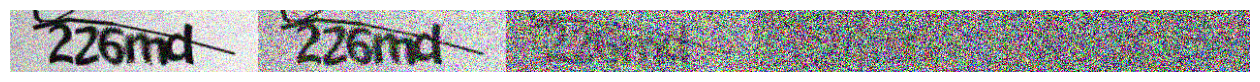

In [20]:
# test our NoiseScheduler
test_scheduler = NoiseScheduler()
time_steps = torch.tensor([100, 200, 500, 700, 900])
sample = torch.cat([dataset[0][0].unsqueeze(0)] * time_steps.shape[0], dim=0)
noise = torch.randn_like(sample)
noisy_samples = test_scheduler.add_noise(sample, noise , time_steps)
plot_images(noisy_samples)

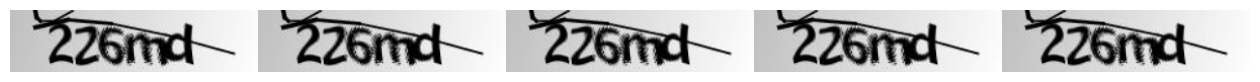

In [21]:
denoised_sample = test_scheduler.denoise(noisy_samples, noise, time_steps)
plot_images(denoised_sample)

## Train and Sampling (15 points)
We'll use the DDPM class to train our diffusion model and generate samples. Complete the train and sample methods according to the provided instructions.

In [29]:
class DDPM:
    """
    A class for training and sampling from a Denoising Diffusion Probabilistic Model (DDPM).

    Args:
        sample_size (tuple): Size of the input samples (channels, height, width).
        network (torch.nn.Module): The UNet network for denoising.
        optimizer (torch.optim.Optimizer): Optimizer for training the network.
        criterion (torch.nn.Module): Loss criterion for training.
        noise_shdeduler (NoiseScheduler): Scheduler for adding noise and denoising.
        device (torch.device): Device to perform computations on.
        lr_scheduler (optional): Learning rate scheduler. Defaults to None.
    """
    def __init__(self, sample_size , network, optimizer, criterion, noise_shdeduler: NoiseScheduler, device, lr_scheduler=None):
        self.sample_size = sample_size
        self.network = network.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = noise_shdeduler
        self.device = device
        self.lr_scheduler = lr_scheduler

    def train(self, dataloader, epochs, **kwargs):
        """
        Train the DDPM model.

        Args:
            dataloader (torch.utils.data.DataLoader): DataLoader for training data.
            epochs (int): Number of epochs to train.
            **kwargs: Additional keyword arguments.

        Returns:
            list: History of training losses.
        """
        history = []
        for epoch in range(epochs):
        ##########################################################
        # TODO (5 points):
        # Complete the train loop:
        # Sample a time step t and create noisy images for the t'th step
        # of the diffusion noise scheduler, Then predict the noise using
        # self.network. Compute the loss and backpropagate.
        ##########################################################
            total_loss = []
            for batch, label in dataloader:
                batch = batch.to(self.device)

                timesteps = torch.randint(0, self.scheduler.T, batch.shape[0:1], device=self.device)
                noises = torch.randn_like(batch, device=self.device)
                noisy_batch = self.scheduler.add_noise(batch, noises, timesteps)

                output = self.network(noisy_batch, timesteps)
                loss = self.criterion(output, noises)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                if self.lr_scheduler:
                    self.lr_scheduler.step()
                total_loss.append(loss.item())
        #################### END TODO ############################

            mean_loss = np.mean(total_loss)
            lr_str = f"[lr: {self.lr_scheduler.get_last_lr()[0]}]" if self.lr_scheduler else ''
            print(f"[Epoch: {epoch+1}/{epochs}] [loss: {mean_loss:.4f}] {lr_str}")
            if (epoch+1) % 10 == 0:
                self.sample(5, plot=True)

            history.append(mean_loss)

        return history

    def sample(self, n, plot=True):
        """
        Sample from the trained DDPM model.

        Args:
            n (int): Number of images to sample.
            plot (bool, optional): Whether to plot the sampled images. Defaults to True.
            label (str, optional): Label for the sampled images. Defaults to None.

        Returns:
            torch.Tensor: Sampled image tensor.
        """
    ##########################################################
    # TODO (7 points):
    # Generate a random pattern x Then denoise x for all of the
    # noise_scheduler time steps.
    # Choose n images from the generated images during denoising
    # time steps (xs). The purpose is to show how denoising
    # converts the pure noise to an image after self.T time steps.
    ##########################################################
        with torch.no_grad():
          xs = []
          noisy_sample = torch.randn(self.sample_size, device=self.device).unsqueeze(0)
          for t in reversed(range(self.scheduler.T)):
              noise = self.network(noisy_sample, torch.tensor([t], device=self.device))
              denoised_sample = self.scheduler.denoise(noisy_sample, noise, [t])
              if t % (self.scheduler.T // n) == 0:
                  xs.append(denoised_sample.clone())
              del noisy_sample
              noisy_sample = denoised_sample
        samples = torch.concatenate(xs, dim=0)
        if plot:
          plot_images(samples)
        return samples

    #################### END TODO ############################


To build and train our DDPM, first instantiate a UNet, noise scheduler, optimizer, and loss function. Then, create a DDPM object using them. To begin the training process, call the train method with our dataloader and the required number of epochs. It's recommended to use a learning rate scheduler with warmup steps (e.g., cosine schedule) to facilitate faster model convergence.

In [41]:
# define hyper params
IMG_SIZE = (3, 64, 256)
LR = 0.0001
EPOCHS = 100

In [42]:
##########################################################
# TODO (3 points):
# Create required objcts to DDPM.
##########################################################
model = UNet(IMG_SIZE[0], IMG_SIZE[0], temb_size=512, norm_groups=32, dropout=0, num_layers=2)
scheduler = NoiseScheduler()
optimizer = optim.Adam(model.parameters(), LR)
criterion = nn.MSELoss()
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                              T_max=len(dataloader) * EPOCHS,
                                                              last_epoch=-1,
                                                              eta_min=1e-9)
#################### END TODO ############################

In [43]:
ddpm = DDPM(
    sample_size=IMG_SIZE,
    network=model,
    optimizer=optimizer,
    criterion=criterion,
    noise_shdeduler=scheduler,
    device=DEVICE,
    lr_scheduler=lr_scheduler
) # You can pass your arguments to the call.


In [ ]:
##########################################################
# TODO:
# Create required objcts to DDPM.
##########################################################
# please save and copy your final trained model into google drive and put its public download link here:
# download link: ...
torch.save(ddpm.network.state_dict(), 'ddpm.pth')
#################### END TODO ############################

[Epoch: 1/100] [loss: 0.0956] [lr: 9.997532826500645e-05]
[Epoch: 2/100] [loss: 0.0340] [lr: 9.990133740804938e-05]
[Epoch: 3/100] [loss: 0.0252] [lr: 9.977810044917175e-05]
[Epoch: 4/100] [loss: 0.0215] [lr: 9.96057390083732e-05]
[Epoch: 5/100] [loss: 0.0171] [lr: 9.938442318558652e-05]
[Epoch: 6/100] [loss: 0.0162] [lr: 9.911437139280911e-05]
[Epoch: 7/100] [loss: 0.0176] [lr: 9.879585013855651e-05]
[Epoch: 8/100] [loss: 0.0127] [lr: 9.842917376485118e-05]
[Epoch: 9/100] [loss: 0.0145] [lr: 9.801470413700448e-05]
[Epoch: 10/100] [loss: 0.0150] [lr: 9.755285028649977e-05]


/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


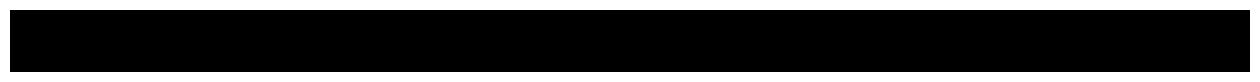

[Epoch: 11/100] [loss: 0.0118] [lr: 9.704406800732707e-05]
[Epoch: 12/100] [loss: 0.0124] [lr: 9.648885940616991e-05]
[Epoch: 13/100] [loss: 0.0121] [lr: 9.588777240688658e-05]
[Epoch: 14/100] [loss: 0.0128] [lr: 9.524140020977509e-05]


KeyboardInterrupt: 

In [44]:
history = ddpm.train(dataloader, EPOCHS)

In [ ]:
import gc

# del ddpm
gc.collect()
torch.cuda.empty_cache()

Generate random samples from the trained model.

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


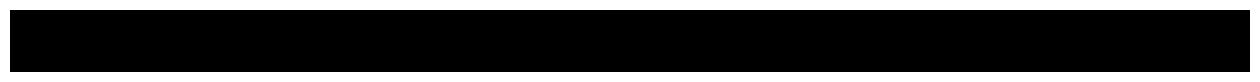

In [32]:
s = ddpm.sample(5)

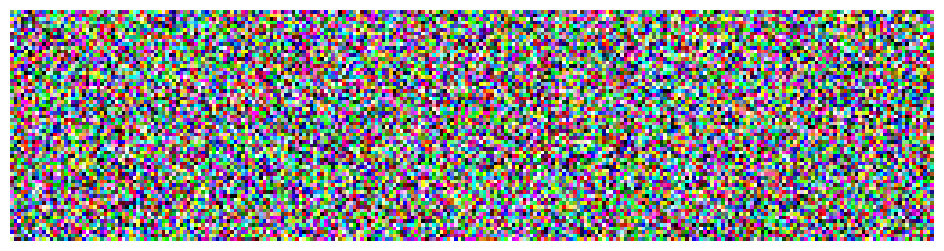

In [40]:
noisy_sample = torch.randn(IMG_SIZE).unsqueeze(0)
plot_images(noisy_sample)
# noisy_sample.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

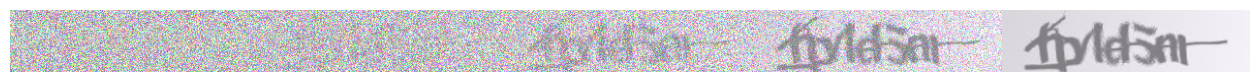

In [ ]:
s = ddpm.sample(5)

In [ ]:
# plot loss history
plt.plot(np.arange(EPOCHS), history)
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')

## Conditional DDPM (15 + 17 points)

Generating random CAPTCHA images without knowing their text labels is pointless and impractical. To enhance the realism of our CAPTCHA generator, we need to modify our model to generate images corresponding to given CAPTCHA text inputs.

To achieve this, we can adapt our model to take the CAPTCHA text as input and generate the corresponding image. One approach is to modify the DDPM class and U-Net architecture to incorporate this functionality. Alternatively, we can design a new architecture specifically tailored for this task.

Here's a summary of the required steps:
1. Describe the solution for generating CAPTCHA images corresponding to input text. (4 Points)
2. Implement the idea and modify the model accordingly. (7 Points)
3. Train the model and demonstrate its performance by generating sample images. (4 Points)

Achieving good results is a bonus (20 Points), but the primary focus should be on implementing the solution effectively.
Our criteria for considering a genereded sample as "good" is that the sample includes understandable input text with same order, belowing example is a good one:

  0%|          | 0/1000 [00:00<?, ?it/s]

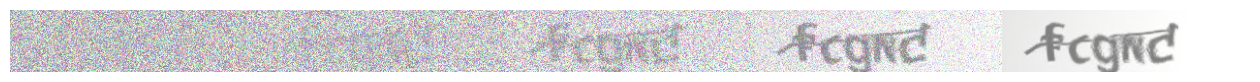

In [ ]:
s = ddpm.sample(5, 'fcgnd')

In [ ]:
class Tokenizer:
    def __init__(self) -> None:
        self.tokens = [chr(i) for i in range(ord('a'), ord('z') + 1)] + [str(i) for i in range(11)]
        self.vocab_size = len(self.tokens)

    def to_ids(self, tokens):
        ids = []
        for token in tokens:
            ids.append(torch.tensor([self.tokens.index(char) for char in token]))
        return torch.stack(ids, dim=0)

    def to_token(self, ids):
        return ''.join([self.tokens[id] for id in ids])

In [ ]:
class ContexUNet(nn.Module):
    """
    UNet class defines a U-Net architecture.

    Args:
        in_ch (int): Number of input channels.
        out_ch (int): Number of output channels.
        temb_size (int): Size of the time embedding.
        norm_groups (int): Number of groups for normalization.
        dropout (float, optional): Dropout rate. Defaults to 0.
        num_layers (int, optional): Number of layers. Defaults to 2.
        num_heads (int, optional): Number of attention heads. Defaults to 8.
        **kwargs: Additional keyword arguments.
    """
    def __init__(self, in_ch, out_ch, temb_size, norm_groups, ctx_size=5, dropout=0, num_layers=2, num_heads=8, **kwargs):
        super(ContexUNet, self).__init__()

        # Initialize parameters
        self.temb_size = temb_size
        self.norm_groups = norm_groups
        self.num_res_layers = num_layers
        self.dropout = dropout
        self.num_attention_heads = num_heads
        self.pos_embedding_dim = 128

        self.pos_encoding = SinusoidalPosition(self.pos_embedding_dim)
        self.time_proj = nn.Sequential(
            nn.Linear(self.pos_embedding_dim, temb_size),
            nn.SiLU(),
            nn.Linear(temb_size, temb_size)
        )

        # contex
        self.tokenizer = Tokenizer()
        self.cond_proj1 = nn.Sequential(
            nn.Embedding(self.tokenizer.vocab_size, 128),
            nn.SiLU(),
        )
        self.cond_proj2 = nn.Sequential(
            nn.Linear(ctx_size, 1),
            nn.SiLU()
        )
        self.cond_proj3 = nn.Linear(128, 128)
        # down blocks
        self.conv_in = nn.Conv2d(in_ch, 128, kernel_size=3, padding=1)
        self.down = nn.ModuleList([
            DownBlock(128, 128, temb_size, dropout, norm_groups, num_layers),
            DownBlock(128, 128, temb_size, dropout, norm_groups, num_layers),
            DownBlock(128, 256, temb_size, dropout, norm_groups, num_layers),
            AttentionDownBlock(256, 256, temb_size, dropout, norm_groups, num_layers, num_heads),
            AttentionDownBlock(256, 512, temb_size, dropout, norm_groups, num_layers, num_heads),
            DownBlock(512, 512, temb_size, dropout, norm_groups, num_layers, add_sampling=False),
        ])
        # mid blocks
        self.mid = MidBlock(512, temb_size, dropout, norm_groups)
        # up blocks
        self.up = nn.ModuleList([
            UpBlock(512, 512, 512, temb_size, dropout, norm_groups, num_layers + 1),
            AttentionUpBlock(512, 256, 256, temb_size, dropout, norm_groups, num_layers + 1, num_heads),
            AttentionUpBlock(256, 256, 256, temb_size, dropout, norm_groups, num_layers + 1, num_heads),
            UpBlock(256, 128, 128, temb_size, dropout, norm_groups, num_layers + 1),
            UpBlock(128, 128, 128, temb_size, dropout, norm_groups, num_layers + 1),
            UpBlock(128, 128, 128, temb_size, dropout, norm_groups, num_layers + 1, add_sampling=False),
        ])

        self.to_out = nn.Sequential(
            nn.GroupNorm(norm_groups, 128),
            nn.SiLU(),
            nn.Conv2d(128, out_ch, kernel_size=3, padding=1)
        )


    def forward(self, x, t, c):
        """
        Forward pass through the UNet model.

        Args:
            x (torch.Tensor): Input tensor.
            t (torch.Tensor): Input tensor representing time steps.

        Returns:
            torch.Tensor: Output tensor.
        """
        t = self.pos_encoding(t)
        t = self.time_proj(t)

        c = self.tokenizer.to_ids(c)
        c = self.cond_proj1(c)
        c = self.cond_proj2(c.permute(0, 2, 1)).squeeze(2)
        c = self.cond_proj3(c).unsqueeze(-1).unsqueeze(-1)

        x = self.conv_in(x)
        x = c * x
        hiddens = []
        for block in self.down:
            x, hidden = block(x, t)
            hiddens.append(hidden)

        x = self.mid(x, t)

        for block, hidden in zip(self.up, reversed(hiddens)):
            x = block(x, t, hidden)

        x = self.to_out(x)
        return x


In [ ]:
class ContexDDPM:
    """
    A class for training and sampling from a Denoising Diffusion Probabilistic Model (DDPM).

    Args:
        sample_size (tuple): Size of the input samples (channels, height, width).
        network (torch.nn.Module): The UNet network for denoising.
        optimizer (torch.optim.Optimizer): Optimizer for training the network.
        criterion (torch.nn.Module): Loss criterion for training.
        noise_shdeduler (NoiseScheduler): Scheduler for adding noise and denoising.
        device (torch.device): Device to perform computations on.
        lr_scheduler (optional): Learning rate scheduler. Defaults to None.
    """
    def __init__(self, sample_size , network, optimizer, criterion, noise_shdeduler: NoiseScheduler, device, lr_scheduler=None):
        self.sample_size = sample_size
        self.network = network.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = noise_shdeduler
        self.device = device
        self.lr_scheduler = lr_scheduler

    def train(self, dataloader, epochs, **kwargs):
        """
        Train the DDPM model.

        Args:
            dataloader (torch.utils.data.DataLoader): DataLoader for training data.
            epochs (int): Number of epochs to train.
            **kwargs: Additional keyword arguments.

        Returns:
            list: History of training losses.
        """
        history = []
        for epoch in range(epochs):
            total_loss = []
            for batch, labels in dataloader:
                batch = batch.to(self.device)

                timesteps = torch.randint(0, self.scheduler.T, batch.shape[0:1], device=self.device)
                noises = torch.randn_like(batch, device=self.device)
                noisy_batch = self.scheduler.add_noise(batch, noises, timesteps)

                output = self.network(noisy_batch, timesteps, labels)
                loss = self.criterion(output, noises)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                if self.lr_scheduler:
                    self.lr_scheduler.step()
                total_loss.append(loss.item())

            mean_loss = np.mean(total_loss)
            lr_str = f"[lr: {self.lr_scheduler.get_last_lr()[0]}]" if self.lr_scheduler else ''
            print(f"[Epoch: {epoch+1}/{epochs}] [loss: {mean_loss:.4f}] {lr_str}")
            if (epoch+1) % 10 == 0:
                self.sample(5, plot=True)

            history.append(mean_loss)

        return history

    def sample(self, n, c, plot=True):
        """
        Sample from the trained DDPM model.

        Args:
            n (int): Number of images to sample.
            plot (bool, optional): Whether to plot the sampled images. Defaults to True.
            label (str, optional): Label for the sampled images. Defaults to None.

        Returns:
            torch.Tensor: Sampled image tensor.
        """
        with torch.no_grad():
          xs = []
          noise = torch.randn(self.sample_size, device=self.device).unsqueeze(0)
          for t in reversed(range(self.scheduler.T)):
              new_noise = self.network(noise, torch.tensor([t], device=self.device), [c])
              if t % (self.scheduler.T // n) == 0:
                  xs.append(new_noise.clone())
              del noise
              noise = new_noise
        samples = torch.concatenate(xs, dim=0)
        if plot:
          plot_images(samples)
        return samples


In [ ]:

model = ContexUNet(IMG_SIZE[0], IMG_SIZE[0], temb_size=512, norm_groups=32, dropout=0, num_layers=2)
scheduler = NoiseScheduler()
optimizer = optim.Adam(model.parameters(), LR)
criterion = nn.MSELoss()
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,
                                                    T_max=len(dataloader) * EPOCHS,
                                                    last_epoch=-1,
                                                    eta_min=1e-9)

In [ ]:
cddpm = ContexDDPM(
    sample_size=IMG_SIZE,
    network=model,
    optimizer=optimizer,
    criterion=criterion,
    noise_shdeduler=scheduler,
    device=DEVICE,
    lr_scheduler=lr_scheduler
) # You can pass your arguments to the call.


In [ ]:
ctx_history = cddpm.train(dataloader, EPOCHS)

In [ ]:
ctx_s = cddpm.sample(5, 'fcgnd')